<a href="https://colab.research.google.com/github/ces1406/IAA/blob/master/tpiaa_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Acceso a Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Función para leer el conjunto de datos

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import gzip
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import sklearn.metrics

data_dir=pathlib.Path('/content/drive/My Drive/iaa/imagenes-iaa')

batch_size= 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)
#plt.figure(figsize=(10, 10))
#for images, labels in train_ds.take(1):
#  for i in range(9):
#    ax = plt.subplot(3, 3, i + 1)
#    plt.imshow(images[i].numpy().astype("uint8"))
#    plt.title(class_names[labels[i]])
#    plt.axis("off")

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

num_classes = 3
#data_augmentation = keras.Sequential(
#  [
#    layers.experimental.preprocessing.RandomFlip("horizontal", 
#                                                 input_shape=(img_height, 
#                                                              img_width,
#                                                              3)),
#    layers.experimental.preprocessing.RandomRotation(0.1),
#    layers.experimental.preprocessing.RandomZoom(0.1),
#  ]
#)
model = Sequential([
#  data_augmentation,
#  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
#  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
    #optimizer ='sgd',
    #loss='mse',
    #metrics=[tf.keras.metrics.AUC(multi_label=True)]
    )

model.summary()

def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Normalize the confusion matrix.
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure
#test_labels = class_names
#test_images = train_ds
#class MyCustomCallback(tf.keras.callbacks.Callback):
#  def on_epoch_end(self, epoch, logs=None):
#    keras.metrics.confusion_matrix(y_test, y_pred)
#    print('La perdida promedio para la epoch {} es {:7.2f} y el MAE es {:7.2f}.'.format(epoch, logs['loss']))
def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
  test_pred_raw = model.predict(val_ds)
  test_pred = np.argmax(test_pred_raw, axis=1)

  # Calculate the confusion matrix.
  cm = sklearn.metrics.confusion_matrix(class_names, test_pred)
  # Log the confusion matrix as an image summary.
  figure = plot_confusion_matrix(cm, class_names=class_names)
  cm_image = plot_to_image(figure)

  # Log the confusion matrix as an image summary.
  with file_writer_cm.as_default():
    tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# Define the per-epoch callback.
MyCallback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

#import datetime

class MyCustomCallback(tf.keras.callbacks.Callback):
  def on_test_batch_begin(self,batch,logs=None):
    print('Batch->begin')
  def on_test_batch_end(self,bach,logs=None):
    print('Batch->end')
  def on_epoch_end(self,epoch,logs=None):
    print('Epoch->end')
  """def on_train_batch_begin(self, batch, logs=None):
    print('Entrenamiento: batch {} comienza en {}'.format(batch, datetime.datetime.now().time()))
  def on_train_batch_end(self, batch, logs=None):
    print('Entrenamiento: batch {} termina en {}'.format(batch, datetime.datetime.now().time()))
  def on_test_batch_begin(self, batch, logs=None):
    print('Evaluacion: batch {} comienza en {}'.format(batch, datetime.datetime.now().time()))
  def on_test_batch_end(self, batch, logs=None):
    print('Evaluacion: batch {} termina en {}'.format(batch, datetime.datetime.now().time()))
"""

epochs=14

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
  #callbacks=[MyCallback]
)

data_dir2 = pathlib.Path('/content/drive/My Drive/iaa/pruebas/cubismoprueba/gris1.jpg')
img = keras.preprocessing.image.load_img(
    data_dir2, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
test = model.predict(img_array)
score = tf.nn.softmax(test[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

# Use the model to predict the values from the validation dataset.
#test_pred_raw = model.predict(val_ds)
#test_pred = np.argmax(test_pred_raw, axis=1)

  # Calculate the confusion matrix.
#cm = sklearn.metrics.confusion_matrix(class_names, test_pred)
  # Log the confusion matrix as an image summary.
#figure = plot_confusion_matrix(cm, class_names=class_names)
#cm_image = plot_to_image(figure)

  # Log the confusion matrix as an image summary.
#with file_writer_cm.as_default():
#  tf.summary.image("Confusion Matrix", cm_image, step=epoch)


#def plot_confusion_matrix(cm, class_names):

#acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']
#loss=history.history['loss']
#val_loss=history.history['val_loss']
#epochs_range = range(epochs)
#plt.figure(figsize=(8, 8))
#plt.subplot(1, 2, 1)
#plt.plot(epochs_range, acc, label='Training Accuracy')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
#plt.legend(loc='lower right')
#plt.title('Training and Validation Accuracy')
#plt.subplot(1, 2, 2)
#plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
#plt.legend(loc='upper right')
#plt.title('Training and Validation Loss')
#plt.show()

#print(history.history)

Found 769 files belonging to 3 classes.
Using 616 files for training.
Found 769 files belonging to 3 classes.
Using 153 files for validation.
['cubismo', 'fauvismo', 'puntillismo']
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2

# Pruebas


In [ ]:
import pathlib
import PIL


data_dir=pathlib.Path('/content/drive/My Drive/iaa/pruebas')
imagenes = list(data_dir.glob('puntillismoprueba/*'))
hits = 0
for x in imagenes:
  PIL.Image.open(x)
  img_puntillismo = pathlib.Path(x)
  img = keras.preprocessing.image.load_img(
      img_puntillismo, target_size=(img_height, img_width)
  )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  test = model.predict(img_array)
  score = tf.nn.softmax(test[0])
  if class_names[np.argmax(score)] == 'puntillismo':
    hits+=1
  print(
      "This image {} most likely belongs to {} with a {:.2f} percent confidence."
      .format(x,class_names[np.argmax(score)], 100 * np.max(score))
  )
print("Precission",hits*100/len(imagenes))


This image /content/drive/My Drive/iaa/pruebas/puntillismoprueba/cross12.jpg most likely belongs to puntillismo with a 100.00 percent confidence.
This image /content/drive/My Drive/iaa/pruebas/puntillismoprueba/cross13.jpg most likely belongs to puntillismo with a 98.37 percent confidence.
This image /content/drive/My Drive/iaa/pruebas/puntillismoprueba/cross14.jpg most likely belongs to puntillismo with a 99.99 percent confidence.
This image /content/drive/My Drive/iaa/pruebas/puntillismoprueba/cross15.jpg most likely belongs to puntillismo with a 98.37 percent confidence.
This image /content/drive/My Drive/iaa/pruebas/puntillismoprueba/cross16.jpg most likely belongs to puntillismo with a 99.99 percent confidence.
This image /content/drive/My Drive/iaa/pruebas/puntillismoprueba/cross17.jpg most likely belongs to puntillismo with a 100.00 percent confidence.
This image /content/drive/My Drive/iaa/pruebas/puntillismoprueba/cross18.jpg most likely belongs to puntillismo with a 100.00 pe

##Chequeando la carga de imagenes localmente

56
/content/drive/My Drive/iaa/pruebas/fauvismoprueba/matisse32.jpg


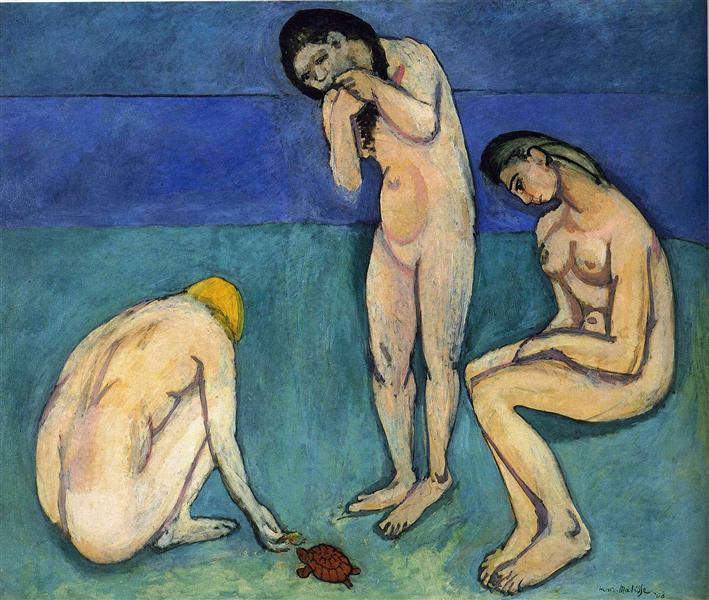

In [ ]:
import pathlib
import PIL

data_dir=pathlib.Path('/content/drive/My Drive/iaa/pruebas')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)
imagenes1 = list(data_dir.glob('fauvismoprueba/*'))
print(str(imagenes1[0]))
PIL.Image.open(str(imagenes1[3]))